# Electronic Structure Calculations using Generalized Ising Hamiltonians

Your final task is to calculate the ground state energy of a hydrogen molecule using a Generalized Ising Hamiltonian:

$ H = E_0 + \sum_i h_i\sigma_i + \sum_{ij} J_{ij}\sigma_i\sigma_j + \sum_{ijk} K_{ijk}\sigma_i\sigma_j\sigma_k + \sum_{ijkl} L_{ijkl}\sigma_i\sigma_j\sigma_k\sigma_l + \cdots $

where the Hamiltonian parameters ($E_0, h_i, J_{ij}, K_{ijk}, L_{ijkl}$) will be provided to you by the `read_generalized_ising_hamiltonian` function below.

These Ising Hamiltonians were produced using the *Iterative Qubit Coupled Cluster* method (https://arxiv.org/abs/1906.11192).

The $H_2$ Ising Hamiltonian only needs 4 spins to fully describe the ground state, hence our Hamiltonian only needs a 4-point interaction at most.

In [6]:
import numpy as np

from abstract_ising import AbstractIsing
from ising_animator import IsingAnimator
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
def read_generalized_ising_hamiltonian(path):
    with open(path, "r") as f:
        f.readline()  # discard first line
        compressed_hamiltonian = [
            tuple(line.strip().split())
            for line in f.readlines()
        ]
    
    num_sites = len(compressed_hamiltonian[0][0])
    hamiltonian_terms = [np.zeros((num_sites,)*i) for i in range(num_sites+1)]

    for sites, val in compressed_hamiltonian:
        num_zs = 0
        site_nums = []
        for i, x in enumerate(sites):
            if x == 'z':
                site_nums.append(i)
                num_zs += 1

        hamiltonian_terms[num_zs][tuple(site_nums)] = float(val)

    return hamiltonian_terms

In [18]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")

print(h)
print(J)
print(K)
print(L)

[0.         0.18262644 0.12584137 0.19100352]
[[ 0.          0.          0.12584137  0.00837708]
 [ 0.          0.          0.          0.1729761 ]
 [ 0.          0.          0.         -0.27288405]
 [ 0.          0.          0.          0.        ]]
[[[ 0.          0.          0.          0.        ]
  [ 0.          0.         -0.26450696  0.17866778]
  [ 0.          0.          0.         -0.00837708]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.16992098]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.         

First, you must write a class that describes the Generalized Ising Model given the arrays containing the Hamiltonian parameters. You will need to write a function which computes energy of the stored spin configuration (see the previous tasks for inspiration), as well as a function which computes the change in energy resulting from a single-spin-flip (you could of course use the naive approach and simply compute the energy of two spin configurations and subtract one from the other).

In [15]:
# Write a class to describe the generalized Ising Model given its Hamiltonian parameters
def spinfield_1d(index, spin_count):
    spins = [1 if digit=='1' else -1 for digit in bin(index)[2:]]
    res = -np.ones(spin_count)
    res[spin_count -len(spins):spin_count] = spins
    return res

class GeneralizedIsingModel(AbstractIsing):
    def __init__(self, E0, h, J, K, L, seed=0):
        super().__init__()
        self.E0 = E0
        self.h = h
        self.J = J
        self.K = K
        self.L = L
        np.random.seed(seed)
        self.num_spins = h.shape[0]
        self.spins = 2*(np.random.rand(self.num_spins) < 0.5) - 1

    def energy(self, spins=None):
        spins = self.spins if spins is None else spins

        interaction1d = spins.dot(self.h)
        interaction2d = spins.dot(self.J.dot(spins))
        interaction3d = np.einsum("ijk,i,j,k", self.K, self.spins, self.spins, self.spins)
        interaction4d = np.einsum("ijkl,i,j,k,l", self.L, self.spins, self.spins, self.spins, self.spins)

        return self.E0 + interaction1d + interaction2d + interaction3d + interaction4d

    def exact(self):
        n = len(self.spins)
        all_one = 2 ** n - 1
        E = np.inf
        for i in range(all_one + 1):
            spins = spinfield_1d(i, n)
            E = min(E, self.energy(spins))
        return E
    
    def energy_diff(self, i):
        diff1d = self.h[i]
        diff2d = self.J[i, :].dot(self.spins) + self.J[:, i].dot(self.spins)
        diff3d = self.K[i, i, :].dot(self.spins) + self.K[:, i, i].dot(self.spins) + self.K[i, :, i].dot(self.spins)
        diff4d = self.L[i, i, i, :].dot(self.spins) + self.L[:, i,i, i].dot(self.spins) + self.L[i, :, i, i].dot(self.spins) +  self.L[i, i, :, i].dot(self.spins)

        return -2 * self.spins[i] * (diff1d + diff2d + diff3d + diff4d)

    def rand_site(self):
        return (np.random.randint(self.num_spins),)

Next you'll run a Monte Carlo simulation for this model at some finite temperature for 1000 steps, printing out the energy of the state every so often

In [19]:
N = 1000
t = np.arange(N+1)
T_i = 400
T_f = 0.1
Ts = T_i * ((T_f/T_i) ** (t/N))

def exp_schedule(T_i, T_f, N):
    t = np.arange(N+1)
    Ts = T_i * ((T_f/T_i) ** (t/N))
    return Ts

def anneal(ising,Ts):
    Es = np.zeros_like(Ts)
    for i, t in enumerate(Ts):
        Es[i] = ising.mc_step(T=t)
    return Es

def calc_once(ising, Ts, include_exact=True):

    ising.method = 'metropolis'
    Es = anneal(ising, Ts)
    Ea = min(Es)

    plt.plot(np.arange(len(Es)), Es)
    plt.plot(np.arange(len(Ts)), np.repeat(Ea, len(Ts)), color='g')
    if include_exact:
        Et = ising.exact()
        print("Exact: ", Et)
        plt.plot(np.arange(len(Ts)), np.repeat(Et, len(Ts)), color='r')
    plt.show()


Now, apply (one of) the annealing procedure(s) you came up with in the previous task to this problem to find a ground state of the system:

Exact:  -1.1299047752322906


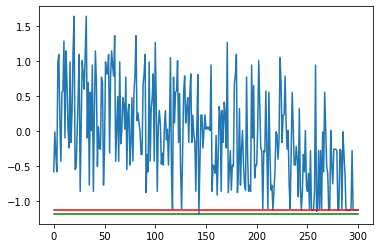

In [20]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")
ising = GeneralizedIsingModel(E0, h, J, K, L)
calc_once(ising, exp_schedule(400, 0.1, 300))
# your annealing code here

Finally, iterate over the entire spin configuration space (this is tractable since we only have 4 spins) to find the exact ground state energy. Compare this energy to the one you found above using your annealer.

In [7]:
# exact ground state calculation

Now, clean up your code a little, and write a for-loop that iterates over all the different values of the Hydrogen seperation distance $R$ available in the `hamiltonians` directory. 

For each $R$ you must:
- Read in the associated Ising Hamiltonian
- Perform an annealed Monte Carlo simulation to find a candidate ground state energy
- Compute the exact ground state energy
- Compare the two results